<a href="https://colab.research.google.com/github/DrJonnyT/Prophet_JT/blob/main/Prophet_JT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!git clone https://github.com/DrJonnyT/Prophet_JT.git
%ls
%pwd

sample_data/


'/content'

In [16]:
##########################################################################################
#    Script to fit and predict using the Facebook time series model                      #
#    Also includes ability to plot diurnal profile comparisons                           #
#                                                                                        #
#    This is free software: you can redistribute it and/or modify it under               #
#    the terms of the GNU General Public License as published by the Free Software       #
#    Foundation, either version 3 of the License, or (at your option) any later          #
#    version.                                                                            #
#                                                                                        #
#    This is distributed in the hope that it will be useful, but WITHOUT                 #
#    ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS       #
#    FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more              #
#    details.                                                                            #
#                                                                                        #
#    You should have received a copy of the GNU General Public License along with        #
#    this repository.  If not, see <http://www.gnu.org/licenses/>.                       #
#                                                                                        #
##########################################################################################
# 2020, author David Topping: david.topping@manchester.ac.uk

#import pyreadr
import os.path
import os
import requests
#import pdb
#import wget
import pandas as pd
import numpy as np
import datetime
import sys
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric


In [17]:

# In this file we first pull all of the data from the DEFRA portal before fitting
# prophet models to each site. This is currently the same as a seperate Script
# for downloaded and analysing the DEFRA data here:
# https://github.com/loftytopping/DEFRA_Air_Quality_data
# The plan is to make this generic for any air quality data

# Also please note that in this file we are testing the Vanilla Prophet model
# The sensitivity to hyperameters and periods of fitting are reserved for the
# individual site analysis

#################################################################################
# Load an existing .csv file with air quality data for fitting. In this example
# this includes

if 'google.colab' in str(get_ipython()):
    frame_aq = pd.read_csv('https://raw.githubusercontent.com/DrJonnyT/Prophet_JT/main/MAN3.csv')
    frame_aq.head()
else:
    frame_aq = pd.read_csv("data/MAN3.csv") #Point this to the right directory at your leisure
    frame_aq.head()





In [18]:
# frame_aq = pd.read_csv(r'Prophet_JT/MAN3.csv')
frame_aq['datetime'] = pd.to_datetime(frame_aq['date'])
frame_aq = frame_aq.sort_values(by='datetime',ascending=True)
frame_aq=frame_aq.set_index('datetime')
#pdb.set_trace()
#################################################################################


In [19]:
################################################################################
# Now load the traffic data from TfGM_Drakewell

# These files give us an insight into representiveness of traffic data
# The following data is from the closes 'Journey Time' BLU measurement point to
# the AURN site.

if 'google.colab' in str(get_ipython()):
  frame_traff = pd.read_csv('https://raw.githubusercontent.com/DrJonnyT/Prophet_JT/main/pvr_2016-01-01_1597d_portland.csv')
else:
  frame_traff = pd.read_csv(r'C:\Users\Dave\Documents\Code\Developing\Traffic_analysis\TfGM_Drakewell\pvr_2016-01-01_1597d_1.csv')  #Edit the path at your leisure

frame_traff.head()

,Sdate,Cosit,LaneNumber,LaneDescription,LaneDirection,DirectionDescription,Volume,Flags,Flag Text,AvgSpeed,PmlHGV
0,2016-03-03 12:00:00,"=""MAC030001144""",1,Channel 1,2,SouthWest,228,0,NaN,NaN,NaN
1,2016-03-03 12:00:00,"=""MAC030001144""",2,Channel 2,2,SouthWest,0,0,NaN,NaN,NaN
2,2016-03-03 13:00:00,"=""MAC030001144""",1,Channel 1,2,SouthWest,228,0,NaN,NaN,NaN
3,2016-03-03 13:00:00,"=""MAC030001144""",2,Channel 2,2,SouthWest,0,0,NaN,NaN,NaN
4,2016-03-03 14:00:00,"=""MAC030001144""",1,Channel 1,2,SouthWest,200,0,NaN,NaN,NaN


In [ ]:




# The additional option below is for a site on Portland street but away from Piccadilly Gardens

# Extract data from Channel 1
frame_traff=frame_traff[frame_traff['LaneDescription']=='Channel 1']
frame_traff['datetime'] = pd.to_datetime(frame_traff['Sdate'])
frame_traff = frame_traff.sort_values(by='datetime',ascending=True)
frame_traff=frame_traff.set_index('datetime')


# Now merge the two dataframes, both Air Quality and Traffic, on the time index
combined_df=pd.merge(frame_traff,frame_aq, left_index=True, right_index=True)
#remove duplicate entries in the index (downloaded multiple CSV files with overlapping times)
combined_df = combined_df.loc[~combined_df.index.duplicated(keep='first')]


#Now produce a box-plot for all entries in dataset.
combined_df["NO2"] = pd.to_numeric(combined_df["NO2"])
combined_df["O3"] = pd.to_numeric(combined_df["O3"])
combined_df["Volume"] = pd.to_numeric(combined_df["Volume"])
combined_df["NO2 per Volume"]=combined_df["NO2"]/combined_df["Volume"]
combined_df["log NO2 per Volume"]=np.log(combined_df["NO2"]/combined_df["Volume"])

f, ax = plt.subplots(2,1,figsize=(6, 5))
ax[1].plot(combined_df.resample('D').mean().index, combined_df['log NO2 per Volume'].resample('D').mean(), color='r')
#ax = f.gca()
ax[1].set(xlabel='Date', ylabel=r"Log(NO2/Volume) $\mu g.m^{-3}$")
ax[1].set_xlim([datetime.date(2019, 9, 28), datetime.date(2020, 5, 10)])
#ax[1].xlabel("Date")
#ax[1].ylabel("Log(NO2/Traffic Volume)")
ax[0].plot(combined_df.resample('D').mean().index, combined_df['Volume'].resample('D').mean(), color='r')
#ax = f.gca()
ax[0].set_xlim([datetime.date(2019, 9, 28), datetime.date(2020, 5, 10)])
ax[0].set(ylabel=r"Volume [$hr^{-1}$]")
plt.show()
plt.close('all')


# Mask to look at typical diurnal profiles before COVID19 lockdown
mask_pre_lockdown = (combined_df.index < '2020-3-23')
f, ax = plt.subplots(3,1,figsize=(12, 5))
sns.boxplot(x=combined_df.loc[mask_pre_lockdown].index.hour, y=combined_df.loc[mask_pre_lockdown]['NO2'],ax=ax[0])
sns.boxplot(x=combined_df.loc[mask_pre_lockdown].index.hour, y=combined_df.loc[mask_pre_lockdown]['O3'],ax=ax[1])
sns.boxplot(x=combined_df.loc[mask_pre_lockdown].index.hour, y=combined_df.loc[mask_pre_lockdown]['log NO2 per Volume'],ax=ax[2])
plt.show()
plt.close('all')
#pdb.set_trace()

# Now produce a set of two combined box-plots according to April before 2020 and for 2020
mask_tag = (combined_df.index.month == 4) & (combined_df.index > '2019-12-30')
combined_df['April_2020'] = mask_tag
booleanDictionary = {True: 'TRUE', False: 'FALSE'}
f, ax = plt.subplots(4,1,figsize=(15, 15))
mask3 = (combined_df.index.month == 4)
sns.boxplot(data=combined_df.loc[mask3],x=combined_df.loc[mask3].index.hour, y=combined_df.loc[mask3]['NO2'],hue='April_2020', ax=ax[0])
sns.boxplot(data=combined_df.loc[mask3],x=combined_df.loc[mask3].index.hour, y=combined_df.loc[mask3]['O3'],hue='April_2020',ax=ax[1])
sns.boxplot(data=combined_df.loc[mask3],x=combined_df.loc[mask3].index.hour, y=combined_df.loc[mask3]['Volume'],hue='April_2020',ax=ax[2])
sns.boxplot(data=combined_df.loc[mask3],x=combined_df.loc[mask3].index.hour, y=combined_df.loc[mask3]['log NO2 per Volume'],hue='April_2020',ax=ax[3])
ax[0].tick_params(axis='x', which='both', bottom='off',labelbottom='off')
ax[1].tick_params(axis='x', which='both', bottom='off',labelbottom='off')
ax[2].tick_params(axis='x', which='both', bottom='off',labelbottom='off')
plt.show()
plt.close('all')
#pdb.set_trace()

In [21]:



######################  Train a Prophet instance to the NO2 per traffic volume ###########################
train_dataset2= pd.DataFrame()
train_dataset2['ds'] = (pd.to_datetime(combined_df['Sdate']))
train_dataset2['O3']=combined_df['O3']
train_dataset2['y']=combined_df['log NO2 per Volume']
#train_dataset2['y']=combined_df['NO2 per Volume']
train_dataset2['Modelled Wind Direction']=combined_df['wd']
train_dataset2['Modelled Wind Speed']=combined_df['ws']
train_dataset2['Modelled Temperature']=combined_df['temp']
train_dataset2['Traffic Volume']=combined_df['Volume']
train_dataset2['NO2']=combined_df['NO2']
train_dataset2 = train_dataset2[train_dataset2.ds != 'End']
train_dataset2 = train_dataset2[train_dataset2['O3'] != 'No data']
train_dataset2 = train_dataset2[train_dataset2['y'] != 'No data']
train_dataset2 = train_dataset2[train_dataset2['Modelled Wind Direction'] != 'No data']
train_dataset2 = train_dataset2[train_dataset2['Modelled Wind Speed'] != 'No data']
train_dataset2 = train_dataset2[train_dataset2['Modelled Temperature'] != 'No data']
train_dataset2=train_dataset2.replace([np.inf, -np.inf], np.nan)
train_dataset2.dropna(inplace=True)
pro_regressor2= Prophet()
# Add additional regressors
pro_regressor2.add_regressor('Modelled Wind Direction')
pro_regressor2.add_regressor('Modelled Wind Speed')
pro_regressor2.add_regressor('Modelled Temperature')
#pro_regressor2.add_regressor('Traffic Volume')
mask_reg1b = (train_dataset2.ds < '2020-3-01')  #Mask is the training dataset- everything before March 2020
mask_reg2b = (train_dataset2.ds >= '2020-3-01') #Test dataset, everything after MArch 2020. So you can compare the business as usual prediction vs measured
mask_reg3b = (train_dataset2.ds >= '2020-3-25') #Almost same as last one
mask_futureb = (train_dataset2.ds > '2019-12-01') #Everything post-Dec 2019



In [22]:
# Specify a train and test dataset. Train before March 2020
train_X2= train_dataset2.loc[mask_reg1b]
test_X2= train_dataset2.loc[mask_reg2b]
pro_regressor2.fit(train_X2)
forecast_data2 = pro_regressor2.predict(test_X2)

In [30]:
train_X2.head()

,ds,O3,y,Modelled Wind Direction,Modelled Wind Speed,Modelled Temperature,Traffic Volume,NO2
datetime,,,,,,,,
2016-03-03 12:00:00,2016-03-03 12:00:00,9.47958,-1.134597,291.6,1.6,4.9,228,73.31378
2016-03-03 13:00:00,2016-03-03 13:00:00,15.76603,-1.241034,294.2,3.3,6.9,228,65.91144
2016-03-03 14:00:00,2016-03-03 14:00:00,29.78582,-1.313301,287.2,3.4,7.3,200,53.78619
2016-03-03 15:00:00,2016-03-03 15:00:00,31.18281,-1.495539,267.3,1.6,6.2,233,52.22177
2016-03-03 16:00:00,2016-03-03 16:00:00,22.90066,-1.398265,201.9,1.9,4.3,257,63.48544


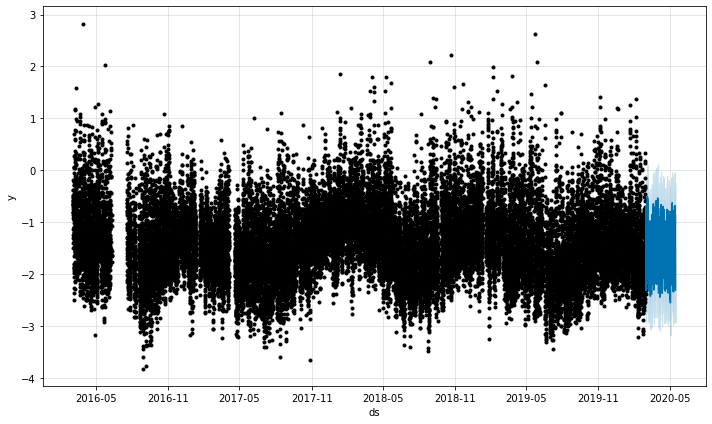

In [28]:
fig1 = pro_regressor2.plot(forecast_data2)

In [ ]:


# From the forecast log(No2/Volume), use the traffic data to predict the levels of NO2
forecast_data2['NO2 from volume']=np.exp(forecast_data2['yhat'].values)*test_X2['Traffic Volume'].values
forecast_data2['NO2 from volume upper']=np.exp(forecast_data2['yhat_upper'].values)*test_X2['Traffic Volume'].values
forecast_data2['NO2 from volume lower']=np.exp(forecast_data2['yhat_lower'].values)*test_X2['Traffic Volume'].values

# Now plot the 'business as usual' NO2 per volume versus the actual calculated from combining
# the AURN data and traffic data
fig =pro_regressor2.plot(forecast_data2, uncertainty=True,figsize=(15, 5))
axes = fig.get_axes()
plt.plot(train_dataset2.loc[mask_reg2b]['ds'], train_dataset2.loc[mask_reg2b]['y'], color='r', label='actual')
ax = fig.gca()
ax.set_xlim([datetime.date(2020, 2, 28), datetime.date(2020, 5, 10)])
ax.set_ylim([-4, 1.5])
axes[0].set_xlabel('Date')
axes[0].set_ylabel('log (NO2 / Traffic volume)')
plt.title('Validation data v. forecast - log NO2 / Traffic volume')
plt.legend();
plt.show()
plt.close('all')
#pdb.set_trace()
#########################################################################################

###########  Train to predict NO2, as per our standard Propher use  #########################
# Now fit two prophet models, one to the just met data and one to the traffic
train_dataset= pd.DataFrame()
train_dataset['ds'] = (pd.to_datetime(combined_df['Sdate']))
train_dataset['O3']=combined_df['O3']
train_dataset['y']=combined_df['NO2']
train_dataset['Modelled Wind Direction']=combined_df['wd']
train_dataset['Modelled Wind Speed']=combined_df['ws']
train_dataset['Modelled Temperature']=combined_df['temp']
train_dataset['Traffic Volume']=combined_df['Volume']
train_dataset['NO2 per Volume']=combined_df['NO2 per Volume']
train_dataset = train_dataset[train_dataset.ds != 'End']
train_dataset = train_dataset[train_dataset['O3'] != 'No data']
train_dataset = train_dataset[train_dataset['y'] != 'No data']
train_dataset = train_dataset[train_dataset['Modelled Wind Direction'] != 'No data']
train_dataset = train_dataset[train_dataset['Modelled Wind Speed'] != 'No data']
train_dataset = train_dataset[train_dataset['Modelled Temperature'] != 'No data']
train_dataset=train_dataset.replace([np.inf, -np.inf], np.nan)
train_dataset.dropna(inplace=True)
mask_reg1 = (train_dataset.ds < '2020-3-01')  #Mask is the training dataset- everything before March 2020
mask_reg2 = (train_dataset.ds >= '2020-3-01') #Test dataset, everything after MArch 2020. So you can compare the business as usual prediction vs measured
mask_reg3 = (train_dataset.ds >= '2020-3-25') #Almost same as last one
mask_future = (train_dataset.ds > '2019-12-01') 

# Build a regressor [using a changpoint scale inferred from the Cross Validation studies]
pro_regressor= Prophet(changepoint_prior_scale=10)
#pro_regressor.add_country_holidays(country_name='UK')
pro_regressor.add_regressor('Modelled Wind Direction')
pro_regressor.add_regressor('Modelled Wind Speed')
pro_regressor.add_regressor('Modelled Temperature')
train_X= train_dataset.loc[mask_reg1]
test_X= train_dataset.loc[mask_reg2]

pro_regressor.fit(train_X)
forecast_data = pro_regressor.predict(test_X)

# Plot the actual data with forecast NO2 AND NO2 from log(NO2/volume) fits
fig =pro_regressor.plot(forecast_data, uncertainty=True,figsize=(15, 5), xlabel='Date', ylabel=r'NO2 $\mu g.m^{-3}$')
plt.plot(train_dataset.loc[mask_reg2]['ds'], train_dataset.loc[mask_reg2]['y'], color='r', label='Measured')
plt.plot(forecast_data['ds'], forecast_data['yhat'], color='tab:blue', label='Forecast')
plt.plot(forecast_data2['ds'], forecast_data2['NO2 from volume'], color='g', label='Forecast using traffic data')
ax = fig.gca()
ax.set_xlim([datetime.date(2020, 2, 28), datetime.date(2020, 5, 10)])
ax.set_ylim([0, 120])
ax.set_xlabel("Date", size=14)
ax.set_ylabel(r'NO2 $\mu g.m^{-3}$', size=14)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
#plt.title('Validation data v. forecast ')
plt.legend(prop={"size":14});
plt.show()
plt.close('all')

# Calculate the % deviation from the predictions based on traffic
forecast_data2['% deviation']=(forecast_data2['NO2 from volume'].values-forecast_data['yhat'].values)/(forecast_data['yhat'].values)*100.0
mask_reg4 = (forecast_data2.ds >= '2020-3-25')

# Create a boxplot looking at measured, forecast with and without traffic
# To do this we are going to concatenate vertically
forecast_normal_df = forecast_data[['ds','yhat']]
forecast_normal_new_df = forecast_normal_df.copy()
forecast_normal_new_df['label'] = 'Forecast'
forecast_normal_new_df=forecast_normal_new_df.rename(columns={"yhat": "y"})
forecast_traffic_df = forecast_data2[['ds','NO2 from volume']]
forecast_traffic_new_df = forecast_traffic_df.copy()
forecast_traffic_new_df['label'] = 'Forecast using traffic data'
forecast_traffic_new_df=forecast_traffic_new_df.rename(columns={"NO2 from volume": "y"})
measured_df = train_dataset.loc[mask_reg2][['ds','y']]
measured_new_df = measured_df.copy()
measured_new_df['label'] = 'Measured'

vertical_stack = pd.concat([forecast_normal_new_df, forecast_traffic_new_df], axis=0)
vertical_stack = pd.concat([vertical_stack, measured_new_df], axis=0)

vertical_stack['ds']=pd.to_datetime(vertical_stack['ds'])
vertical_stack=vertical_stack.set_index('ds')
# Now set the index to be the datetime
f, ax = plt.subplots(1,1,figsize=(12, 5))
sns.boxplot(data=vertical_stack,x=vertical_stack.index.hour, y=vertical_stack['y'],hue='label')
ax.set_xlabel("Hour", size=14)
ax.set_ylabel(r'NO2 $\mu g.m^{-3}$', size=14)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
#plt.title('Validation data v. forecast ')
plt.legend(prop={"size":14});
plt.show()
